In [1]:
import numpy as np
import matplotlib.pyplot as plt
import re
from scipy.integrate import quad
from utils import LogisticMap, CosineKernel, LogisticMapSimulation
from num2tex import num2tex
import sys
sys.path.append("../../")
from DynamicalSystems.koopman_regression import KernelRidgeRegression, ReducedRankRegression, PrincipalComponentRegression, RandomizedReducedRankRegression
from DynamicalSystems.kernels import RBF
from simulation import N, kernel, parameters, statistics, tikhonov_regs

In [2]:
rank = parameters['ranks']
estimators = parameters['estimators']
simulation = LogisticMapSimulation(kernel, parameters, statistics, N = N)

Init: Transfer matrix: 100%|██████████| 21/21 [00:00<00:00, 25.24it/s]


In [3]:
#[train_repetitions, eig_size, estimators, tikhonov_regs]
eigvals = np.load('_tmp_eigenvalues.npy')
#[2(mean,std), estimators, tikhonov_regs]
train_errors = np.load('_tmp_train_errors.npy')
test_errors = np.load('_tmp_test_errors.npy')

In [12]:
true_evals = simulation.logistic._evals
num_to_compare = 5
delta = 0
true_evals = simulation._preprocess_eigs(true_evals)[delta:num_to_compare + delta]

eigenvalue_errors = []
for ev in true_evals:
    arg_mins = np.argmin(np.abs(eigvals - ev), axis=1)[:, None,...]
    mins = np.take_along_axis(eigvals, arg_mins, axis=1)
    mins -= ev
    diff = np.abs(mins[:,0,...])
    mean = diff.mean(axis=0)
    std = diff.std(axis=0)
    eigenvalue_errors.append([mean, std])

#[true_eigs, 2(mean,std), estimators, tikhonov_regs]
eigenvalue_errors = np.array(eigenvalue_errors)

In [14]:
np.abs(true_evals)

array([1.        , 0.27173302, 0.27173302, 0.02665459, 0.02211876])

In [10]:
def only_upper(s):
    upper_chars = ""
    for char in s:
        if char.isupper():
            upper_chars += char
    return upper_chars
def format_results_for_latex(num_eigs = 2):
    full_strs = []
    for est_idx, estimator in enumerate(estimators):
        #estimator_name = re.sub(r"(\w)([A-Z])", r"\1 \2", estimator.__name__) + " & "
        estimator_name = only_upper(estimator.__name__) + " & "
        _strs = [estimator_name]
        err_tuple = (train_errors, test_errors) + tuple([eigenvalue_errors[idx] for idx in range(num_eigs)])
        for _err_idx, _err in enumerate(err_tuple):
            _zeros = np.abs(_err[0,est_idx]) >= 1e-12
            _masked_err = _err[:, est_idx, _zeros]
            min_err_idx = np.argmin(_masked_err[0])
            mean = num2tex(_masked_err[0, min_err_idx])
            std = num2tex(_masked_err[1, min_err_idx])
            min_err = "${:5.2g} \pm {:5.2g}$".format(mean, std)
            if _err_idx == len(err_tuple) - 1:
                min_err += " \\\\"
            else:
                min_err += " & "
            _strs.append(min_err)
        full_strs.append(''.join(_strs))
    for _s in full_strs:
        print(_s)
format_results_for_latex()

KRR & $0.032 \pm 0.00057$ & $ 0.13 \pm 0.00068$ & $7.9 \times 10^{-7} \pm 5.7 \times 10^{-7}$ & $ 0.13 \pm 0.045$ \\


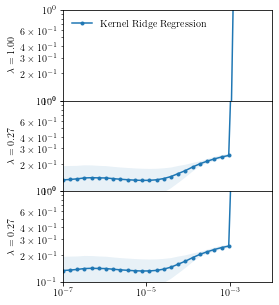

In [8]:
num_above_threshold = 0
fig, axes = plt.subplots(num_to_compare, 1, sharex=True, figsize=(3.75,5))
ax_idx = -1
for ev_idx, ev in enumerate(true_evals):
    ax = axes[ev_idx]
    for est_idx, estimator in enumerate(estimators):     
        mean = eigenvalue_errors[ev_idx, 0, est_idx]
        std = eigenvalue_errors[ev_idx, 1, est_idx]
        ax.fill_between(tikhonov_regs, mean - std, mean + std, alpha = 0.1)
        ax.plot(tikhonov_regs, mean, '.-', label = re.sub(r"(\w)([A-Z])", r"\1 \2", estimator.__name__))
        ax.set_xmargin(0)
        #ax.legend(frameon=False)
    ax.set_ylabel(r"$\lambda = {:10.2f}$".format(np.abs(ev)))  
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylim(1e-1,1)
    if ev_idx == 1:
        ax.set_xlabel(r"Regularization parameter $\gamma$")
    if ev_idx == 0:
        ax.legend(frameon=False, loc ='upper left')
plt.subplots_adjust(hspace=0)
#plt.savefig("eigval_approximation.pdf")


NameError: name 'colors' is not defined

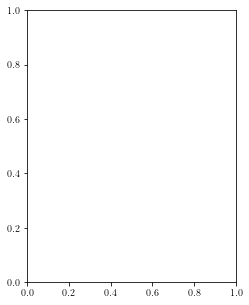

In [7]:
rank = parameters['ranks']
estimators = parameters['estimators']
styles = ['-', '-.']
num_above_threshold = 0
fig, ax = plt.subplots(1, 1, sharex=True, figsize=(3.75,5))
for ev_idx, ev in enumerate(true_evals[:2]):
    arg_mins = np.argmin(np.abs(eigvals - ev), axis=1)[:, None,...]
    mins = np.take_along_axis(eigvals, arg_mins, axis=1)
    mins -= ev
    for est_idx, estimator in enumerate(estimators):
        diff = np.abs(mins[:,0,est_idx,:])
        mean = diff.mean(axis=0)
        std = diff.std(axis=0)
        ax.fill_between(tikhonov_regs, mean - std, mean + std,color=colors[est_idx], alpha = 0.1)
        ax.plot(tikhonov_regs, mean, styles[ev_idx], c=colors[est_idx], label = re.sub(r"(\w)([A-Z])", r"\1 \2", estimator.__name__))
        ax.set_xmargin(0)
    ax.set_ylabel(r"$\lambda = {:10.2f}$".format(np.abs(ev)))  
    ax.set_xscale('log')
    ax.set_yscale('log')
    if ev_idx == 1:
        ax.set_xlabel(r"Regularization parameter $\gamma$")
    if ev_idx == 0:
        ax.legend(frameon=False, loc ='lower right')
plt.subplots_adjust(hspace=0)
#plt.savefig("eigval_approximation.pdf")


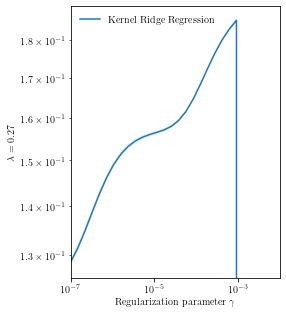

In [7]:
rank = parameters['ranks']
estimators = parameters['estimators']
num_above_threshold = 0
fig, ax = plt.subplots(1, 1, sharex=True, figsize=(3.75,5))
for est_idx, estimator in enumerate(estimators):
    mean = test_errors[0,est_idx, :]
    std =  test_errors[1,est_idx, :]
    ax.fill_between(tikhonov_regs, mean - std, mean + std, alpha = 0.1)
    ax.plot(tikhonov_regs, mean, '-', label = re.sub(r"(\w)([A-Z])", r"\1 \2", estimator.__name__))
    ax.set_xmargin(0)
    #ax.legend(frameon=False)
ax.set_ylabel(r"$\lambda = {:10.2f}$".format(np.abs(ev)))  
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r"Regularization parameter $\gamma$")
ax.legend(frameon=False, loc ='upper left')


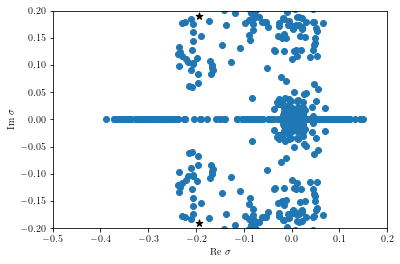

In [26]:
from matplotlib.colors import ListedColormap, to_rgba
from matplotlib.lines import Line2D
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
labels = ['PCR-estimated eigenvalues', 'RRR-estimated eigenvalues', 'True eigenvalues']

for est_idx in range(1):
    cmap_np = np.tile(np.array(to_rgba(colors[est_idx]))[:,None],200).T
    num_grad = 10
    x = np.linspace(0,1,num_grad)
    cmap_np[:num_grad,3] = x
    cmap = ListedColormap(cmap_np)
    eig = []
    for rep_idx in range(100):
        eig.append(eigvals[rep_idx,:,est_idx,0])
    eig = np.array(eig).flatten()
    plt.scatter(np.real(eig), np.imag(eig))     
    
plt.scatter(np.real(true_evals), np.imag(true_evals), s=50, c='k', marker='*')
plt.xlim(-0.5,0.2)
plt.ylim(-0.2,0.2)
plt.xlabel(r"${\rm Re~} \sigma$")
plt.ylabel(r"${\rm Im~} \sigma$")
custom_lines = [Line2D([0], [0], color=colors[0], lw=2),
                Line2D([0], [0], color=colors[1], lw=2),
                Line2D([0], [0], marker='*', color='w',
                          markerfacecolor='k', markersize=15)               
               ]
#plt.legend(custom_lines, labels, frameon=False)


In [ ]:
import scipy.stats
fig_width = 5.5 #Inches
fig_height = 2 #Inches
fig, axes = plt.subplots(ncols=3, figsize=(fig_width, fig_height), tight_layout=True)
x = np.linspace(0, 1, 200)
axes[0].plot(x-0.5, simulation.logistic._noise_dist.pdf(x-0.5), 'k-', lw=0.75)
axes[0].set_xlim(-0.5, 0.5)
axes[0].set_ylim(0, 6)
axes[0].set_title(r"Noise distribution $\Omega$")

axes[1].plot(x, simulation.logistic.pdf(x), 'k-', label=r"$N = 20$", lw=0.75)
axes[1].plot(x, scipy.stats.beta(0.5, 0.5).pdf(x), 'k-.', label='Noiseless', lw=0.75)
axes[1].set_xlim(0, 1)
axes[1].set_ylim(0, 3)
axes[1].legend(frameon=False)
axes[1].set_title(r"Invariant distribution $\pi$")
ev_idx = 1
h = np.zeros(len(x), dtype = np.complex128)
for i in range(N + 1):
    h += simulation.logistic._feature(simulation.logistic.map(x), i)*simulation.logistic._Koop_evecs[i,ev_idx]
    #h += simulation.logistic._feature(simulation.logistic.map(x), i)*simulation.logistic._Koop_evecs[i,ev_idx + 1]
axes[2].plot(x, np.real(h), 'k-', label="Real part", lw=0.75)
axes[2].plot(x, np.imag(h), 'k-.', label="Imag. part", lw=0.75)
axes[2].legend(frameon=False)
axes[2].set_xlim(0, 1)
axes[2].set_ylim(-1, 2.2)
axes[2].set_title(r"Eigenfunction for $\lambda_{2}$")
#plt.savefig("figs/appendix_info.pdf", bbox_inches='tight')